# Reading the data

In [11]:
import pandas as pd
import numpy as np

# 1. Read behaviors.tsv
behaviors_path = '/content/behaviors.tsv'
train_df = pd.read_csv(behaviors_path, sep='\t', header=None, names=[
    "Impression ID", "User ID", "Time", "History", "Impressions"
])
print("Behaviors Data:")
print(train_df.head())

# 2. Read news.tsv
news_path = '/content/news.tsv'
news_df = pd.read_csv(news_path, sep='\t', header=None, names=[
    "News ID", "Category", "SubCategory", "Title", "Abstract", "URL",
    "Title Entities", "Abstract Entities"
])
news_df = news_df.drop(columns=['URL'])
print("\nNews Data:")
print(news_df.head())

# 3. Read entity_embedding.vec
entity_embedding_path = '/content/entity_embedding.vec'
entity_embeddings = {}
with open(entity_embedding_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        entity_id = parts[0]
        embedding = np.array(parts[1:], dtype=float)
        entity_embeddings[entity_id] = embedding


# 4. Read relation_embedding.vec
relation_embedding_path = '/content/relation_embedding.vec'
relation_embeddings = {}
with open(relation_embedding_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        relation_id = parts[0]
        embedding = np.array(parts[1:], dtype=float)
        relation_embeddings[relation_id] = embedding



Behaviors Data:
   Impression ID  User ID                    Time  \
0              1   U87243  11/10/2019 11:30:54 AM   
1              2  U598644   11/12/2019 1:45:29 PM   
2              3  U532401  11/13/2019 11:23:03 AM   
3              4  U593596  11/12/2019 12:24:09 PM   
4              5  U239687   11/14/2019 8:03:01 PM   

                                             History  \
0  N8668 N39081 N65259 N79529 N73408 N43615 N2937...   
1  N56056 N8726 N70353 N67998 N83823 N111108 N107...   
2  N128643 N87446 N122948 N9375 N82348 N129412 N5...   
3  N31043 N39592 N4104 N8223 N114581 N92747 N1207...   
4  N65250 N122359 N71723 N53796 N41663 N41484 N11...   

                                         Impressions  
0  N78206-0 N26368-0 N7578-0 N58592-0 N19858-0 N5...  
1  N47996-0 N82719-0 N117066-0 N8491-0 N123784-0 ...  
2              N103852-0 N53474-0 N127836-0 N47925-1  
3  N38902-0 N76434-0 N71593-0 N100073-0 N108736-0...  
4  N76209-0 N48841-0 N67937-0 N62235-0 N6307-0 N3... 

In [ ]:
train_df['Time'] = pd.to_datetime(train_df['Time'])  # Ensure the column is in datetime format
min_date = train_df['Time'].min()
max_date = train_df['Time'].max()

print("Minimum date:", min_date)
print("Maximum date:", max_date)


Minimum date: 2019-11-09 00:00:25
Maximum date: 2019-11-14 23:59:54


In [12]:
# Remove rows where 'History' is NaN to avoid errors during counting
print(train_df.shape)
train_df = train_df.dropna(subset=['History'])
print(train_df.shape)
# Count the number of history items for each User ID
train_df['History Count'] = train_df['History'].apply(lambda x: len(x.split(' ')))

# Display the User ID and corresponding history count
history_counts = train_df[['User ID', 'History Count']]
print(history_counts.head())
train_df.shape

(2232748, 5)
(2186683, 5)
   User ID  History Count
0   U87243             16
1  U598644             24
2  U532401             16
3  U593596             13
4  U239687            339


(2186683, 6)

In [13]:
import pandas as pd
from collections import defaultdict

# 3. Prepare data for collaborative filtering
interaction_data = defaultdict(lambda: defaultdict(int))  # Using defaultdict to store counts of each news_id for each user

# Iterate over each row in the DataFrame
for index, row in train_df.iterrows():
    user_id = row['User ID']
    impressions = row['Impressions']

    # Check if impressions is not NaN
    if pd.notna(impressions):
        impressions = impressions.split()  # Split the impressions string into a list
        for impression in impressions:
            news_id, clicked = impression.split('-')  # Separate news ID and click indicator
            clicked = int(clicked)  # Convert click indicator to integer
            interaction_data[user_id][news_id] += clicked  # Accumulate clicks for the same news_id

# Combine the impressions into one list for each user
combined_interactions = []

# Create the list for each user, including all impressions with their click counts
for user_id, news_dict in interaction_data.items():
    # Create a list of "news_id-click_count" for the user
    user_impressions = [f"{news_id}-{click_count}" for news_id, click_count in news_dict.items()]
    combined_interactions.append((user_id, " ".join(user_impressions)))

# Create a DataFrame from the combined interactions
interactions_df = pd.DataFrame(combined_interactions, columns=['User ID', 'Impressions_new'])

# Merge the new interactions back with the original train_df
train_df = pd.merge(train_df, interactions_df, on='User ID', how='left')

# Now, train_df will contain the 'Impressions_new' column with all impressions for each user
print(train_df.head())  # Display the first few rows of the updated train_df


   Impression ID  User ID                    Time  \
0              1   U87243  11/10/2019 11:30:54 AM   
1              2  U598644   11/12/2019 1:45:29 PM   
2              3  U532401  11/13/2019 11:23:03 AM   
3              4  U593596  11/12/2019 12:24:09 PM   
4              5  U239687   11/14/2019 8:03:01 PM   

                                             History  \
0  N8668 N39081 N65259 N79529 N73408 N43615 N2937...   
1  N56056 N8726 N70353 N67998 N83823 N111108 N107...   
2  N128643 N87446 N122948 N9375 N82348 N129412 N5...   
3  N31043 N39592 N4104 N8223 N114581 N92747 N1207...   
4  N65250 N122359 N71723 N53796 N41663 N41484 N11...   

                                         Impressions  History Count  \
0  N78206-0 N26368-0 N7578-0 N58592-0 N19858-0 N5...             16   
1  N47996-0 N82719-0 N117066-0 N8491-0 N123784-0 ...             24   
2              N103852-0 N53474-0 N127836-0 N47925-1             16   
3  N38902-0 N76434-0 N71593-0 N100073-0 N108736-0...        

# Keep unique users

In [14]:
# prompt: get the most recent history for each user and only retain that row

# Group by 'User ID' and get the row with the latest 'Time' for each user
train_df_latest = train_df.loc[train_df.groupby('User ID')['Time'].idxmax()]

train_df_latest.shape

# Remove rows where 'History' is NaN to avoid errors during counting
train_df_latest = train_df_latest.dropna(subset=['History'])

# Count the number of history items for each User ID
train_df_latest['History Count'] = train_df_latest['History'].apply(lambda x: len(x.split(' ')))

# Display the User ID and corresponding history count
history_counts = train_df_latest[['User ID', 'History Count']]
print(history_counts.head())

# Remove duplicate User IDs, keeping the first occurrence
train_df = train_df.drop_duplicates(subset='User ID', keep='first').reset_index(drop=True)


train_df_latest.shape

       User ID  History Count
463338      U0              8
451586      U1             72
613095     U10              3
786945    U100             43
611813   U1000              9


(698365, 7)

# Data exploration


News Data:
  News ID   Category               SubCategory  \
0  N88753  lifestyle           lifestyleroyals   
1  N45436       news  newsscienceandtechnology   
2  N23144     health                weightloss   
3  N86255     health                   medical   
4  N93187       news                 newsworld   

                                               Title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1    Walmart Slashes Prices on Last-Generation iPads   
2                      50 Worst Habits For Belly Fat   
3  Dispose of unwanted prescription drugs during ...   
4  The Cost of Trump's Aid Freeze in the Trenches...   

                                            Abstract  \
0  Shop the notebooks, jackets, and more that the...   
1  Apple's new iPad releases bring big deals on l...   
2  These seemingly harmless habits are holding yo...   
3                                                NaN   
4  Lt. Ivan Molchanets peeked over a parapet of s...   

             

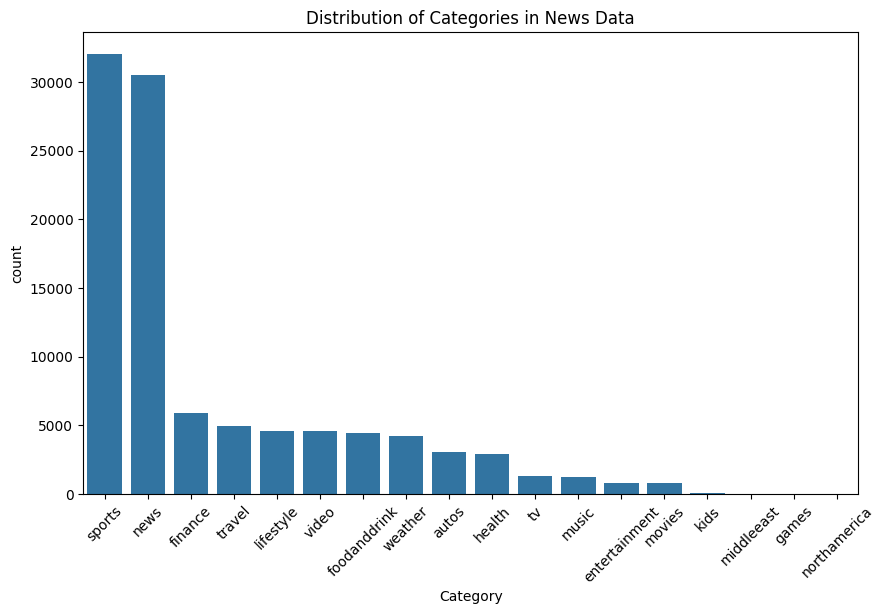

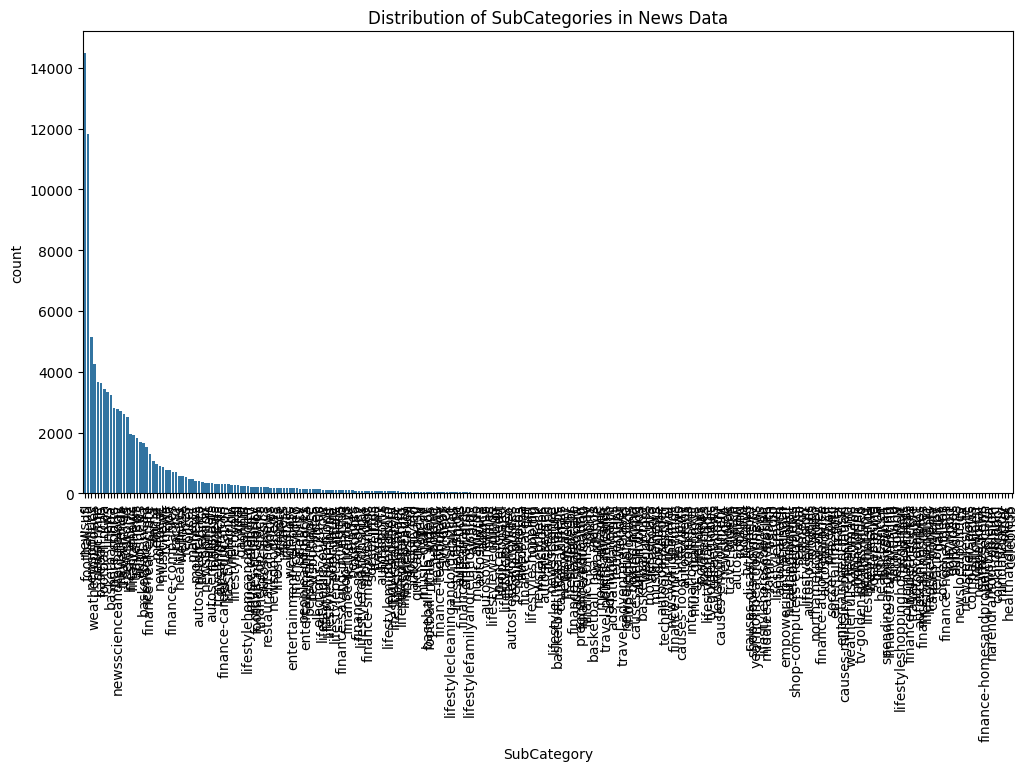


Number of Unique Users in Behaviors Data: 698365
Number of Unique Impressions in Behaviors Data: 698365


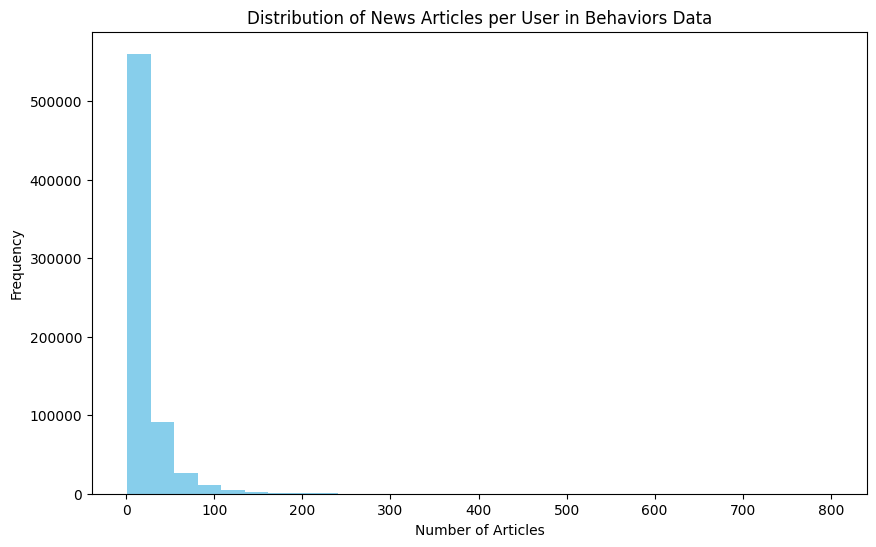

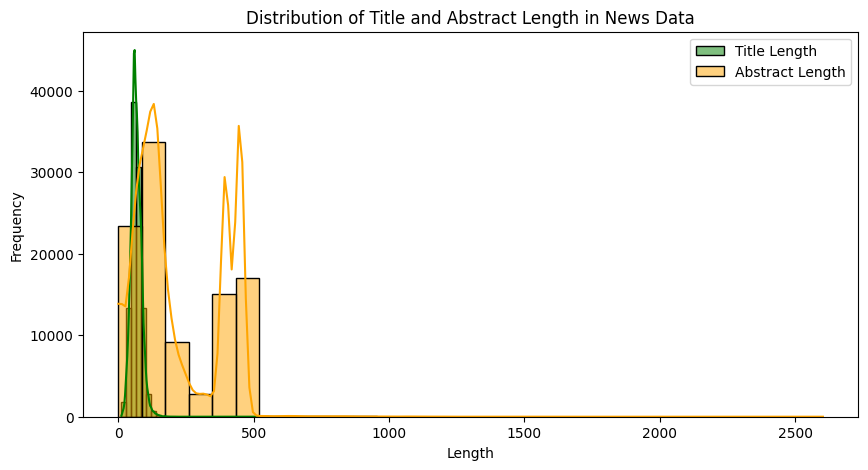

<ipython-input-7-1173489272cf>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_df, x='Frequency', y='News ID', palette="viridis")


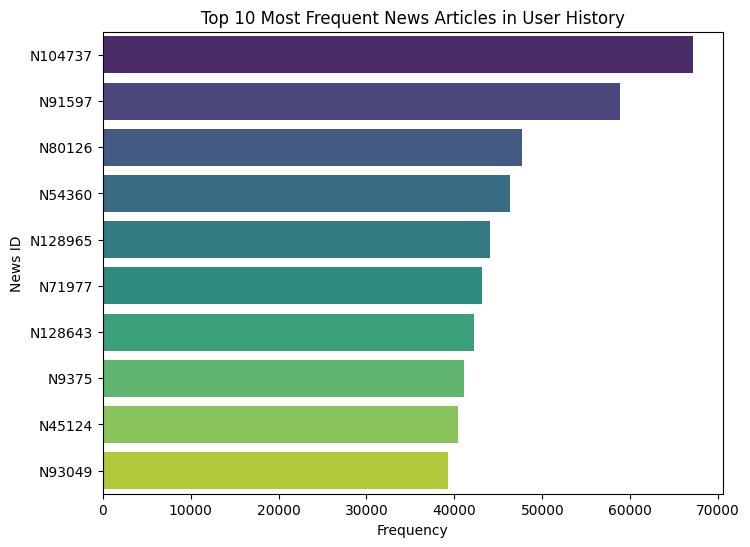

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_df = train_df_latest

print("\nNews Data:")
print(news_df.head())

# Basic Info and Data Types
print("\nBehaviors Data Info:")
print(train_df.info())
print("\nNews Data Info:")
print(news_df.info())

# Check for missing values
print("\nMissing Values in Behaviors Data:")
print(train_df.isnull().sum())
print("\nMissing Values in News Data:")
print(news_df.isnull().sum())

# Basic Statistics
print("\nBasic Statistics for Behaviors Data:")
print(train_df.describe())
print("\nBasic Statistics for News Data:")
print(news_df.describe())

# Distribution of Categories in News Data
plt.figure(figsize=(10, 6))
sns.countplot(data=news_df, x="Category", order=news_df['Category'].value_counts().index)
plt.title("Distribution of Categories in News Data")
plt.xticks(rotation=45)
plt.show()

# Distribution of SubCategories in News Data
plt.figure(figsize=(12, 6))
sns.countplot(data=news_df, x="SubCategory", order=news_df['SubCategory'].value_counts().index)
plt.title("Distribution of SubCategories in News Data")
plt.xticks(rotation=90)
plt.show()

# Unique Users and Impressions in Behaviors Data
print("\nNumber of Unique Users in Behaviors Data:", train_df["User ID"].nunique())
print("Number of Unique Impressions in Behaviors Data:", train_df["Impression ID"].nunique())

# Number of News Articles per User (based on History)
train_df['History Count'] = train_df['History'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
plt.figure(figsize=(10, 6))
plt.hist(train_df['History Count'], bins=30, color='skyblue')
plt.title("Distribution of News Articles per User in Behaviors Data")
plt.xlabel("Number of Articles")
plt.ylabel("Frequency")
plt.show()

# Average Length of Title and Abstract in News Data
news_df['Title Length'] = news_df['Title'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
news_df['Abstract Length'] = news_df['Abstract'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

plt.figure(figsize=(10, 5))
sns.histplot(news_df['Title Length'], color='green', kde=True, bins=30, label='Title Length')
sns.histplot(news_df['Abstract Length'], color='orange', kde=True, bins=30, label='Abstract Length')
plt.legend()
plt.title("Distribution of Title and Abstract Length in News Data")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

# Analyzing Top 10 News Articles by Frequency in Behaviors Data History
from collections import Counter

all_history = ' '.join(train_df['History'].dropna()).split()
top_10_news = Counter(all_history).most_common(10)
top_10_df = pd.DataFrame(top_10_news, columns=['News ID', 'Frequency'])

plt.figure(figsize=(8, 6))
sns.barplot(data=top_10_df, x='Frequency', y='News ID', palette="viridis")
plt.title("Top 10 Most Frequent News Articles in User History")
plt.xlabel("Frequency")
plt.ylabel("News ID")
plt.show()

In [ ]:


# Remove rows with NaN values in 'User ID' column
train_df = train_df.dropna(subset=['User ID'])

# Convert 'User ID' column to string to avoid errors when checking min and max
train_df['User ID'] = train_df['User ID'].astype(str)

# Find min and max of 'User ID'
min_user_id = train_df['User ID'].min()
max_user_id = train_df['User ID'].max()

print("Minimum User ID:", min_user_id)
print("Maximum User ID:", max_user_id)

train_df.shape

Minimum User ID: U0
Maximum User ID: U99999


(698365, 7)

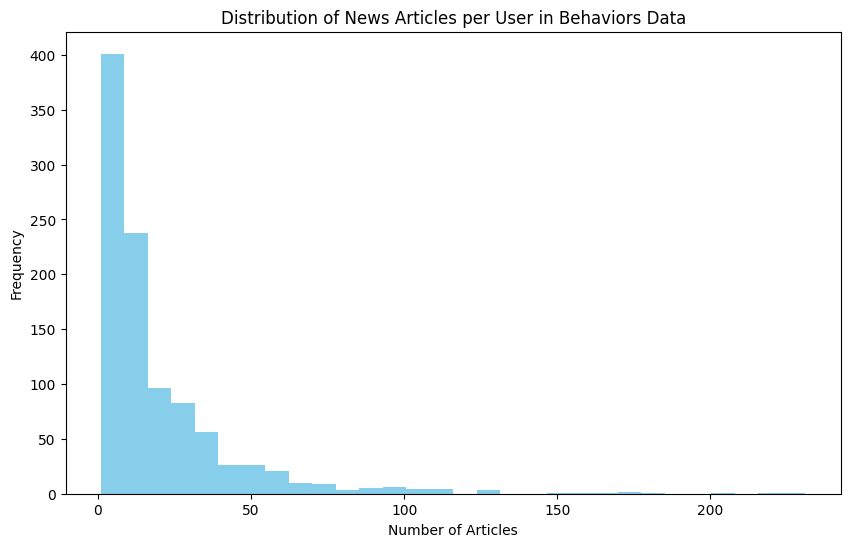

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['History Count'], bins=30, color='skyblue')
plt.title("Distribution of News Articles per User in Behaviors Data")
plt.xlabel("Number of Articles")
plt.ylabel("Frequency")
plt.show()


# CF

In [16]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer



# Convert to DataFrame
train_df_10000 = train_df[:1000]

# Step 1: Split each user's history into lists and handle non-string entries
train_df_10000['History'] = train_df_10000['History'].apply(lambda x: str(x).split() if isinstance(x, str) else [])

# Step 2: Use MultiLabelBinarizer to create the user-item matrix
mlb = MultiLabelBinarizer()
user_item_matrix = pd.DataFrame(mlb.fit_transform(train_df_10000['History']),
                                index=train_df_10000['User ID'],
                                columns=mlb.classes_)

print(user_item_matrix)


         N100  N100022  N100026  N100033  N100063  N100068  N100080  N100091  \
User ID                                                                        
U87243      0        0        0        0        0        0        0        0   
U598644     0        0        0        0        0        0        0        0   
U532401     0        0        0        0        0        0        0        0   
U593596     0        0        0        0        0        0        0        0   
U239687     0        0        0        1        0        0        0        0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
U115243     0        0        0        0        0        0        0        0   
U311138     0        0        0        0        0        0        1        0   
U383721     0        0        0        0        0        0        0        0   
U307781     0        0        0        0        0        0        0        0   
U552836     0        0        0        0

<ipython-input-16-074766e9094c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_10000['History'] = train_df_10000['History'].apply(lambda x: str(x).split() if isinstance(x, str) else [])


# User based CF

In [17]:
from numpy.linalg import svd

user_item_matrix.fillna(0, inplace=True)

u, s, vh = svd(user_item_matrix, full_matrices=False)

u.shape, s.shape, vh.shape

((1000, 1000), (1000,), (1000, 9227))

In [18]:
# Set dimensions for sigma matrix
m = 1000
n = 9227

# Initialize sigma matrix with zeros
sigma = np.zeros((m, m))

# Populate the diagonal elements of sigma with singular values from s
for i in range(min(m, n)):
    sigma[i, i] = s[i]


# Calculate user factor by multiplying U and Sigma
user_factor = np.dot(u, sigma)

all_users = user_item_matrix.index.tolist()

user_ids = train_df_10000['User ID'].unique()  # or wherever your user IDs are stored
user_factor_df = pd.DataFrame(user_factor, index=user_ids)

In [30]:

user_ids = train_df_10000['User ID'].unique()  # or wherever your user IDs are stored
u_factor_df = pd.DataFrame(u, index=user_ids)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def similar_users(user_id, user_factor_matrix, n_elements):

    # Ensure we are using only the specified number of factors/columns
    u2 = user_factor_df.iloc[:, :n_elements]

    # Pre-allocate similarity dictionary
    similarity_dict = {}

    # Get the target user vector
    if user_id not in u2.index:
        raise ValueError(f"User ID {user_id} not found in user factor matrix.")

    target_user_vector = u2.loc[user_id].values.reshape(1, -1)

    # Calculate similarities for all users at once
    all_similarities = cosine_similarity(target_user_vector, u2)[0]

    # Map similarities to user IDs
    similarity_dict = {other_user_id: sim for other_user_id, sim in zip(u2.index, all_similarities)}

    return similarity_dict

def find_unseen_news_for_user(uid, user_factor, n_neighbors, train_data, n_elements):
    # Step 1: Get similar users for the target user
    user_predictions = similar_users(uid, user_factor, n_elements)

    # Step 2: Filter out the target user and get top-n similar users
    sim_users = [(user_id, sim) for user_id, sim in user_predictions.items() if user_id != uid]
    sim_users = sorted(sim_users, key=lambda x: x[1], reverse=True)[:n_neighbors]
    # Step 3: Split the history for the target user and convert it to a set of unique news IDs
    target_user_news = set()

    # Extract the target user's history (which is a Series)
    target_user_history = train_data[train_data['User ID'] == uid]['History']

    # Ensure target_user_history is a single value (it will be a Series with a single entry)
    if not target_user_history.empty:
        # If it's a single value in Series, extract it (assuming it's a string or list of news)
        history = target_user_history.iloc[0]  # Extract the history for the user

        # Handle different types of data in 'History' column (string or list)
        if isinstance(history, str):  # If 'History' is a string, split by a separator (e.g., commas)
            target_user_news.update(history.split(','))
        elif isinstance(history, list):  # If 'History' is already a list, just update directly
            target_user_news.update(history)

    # Step 4: Get news IDs from similar users, split their histories, and collect unique news IDs
    similar_user_ids = [user_id for user_id, _ in sim_users]
    neighbour_news = set()

    # Get the histories of similar users
    similar_users_history = train_data[train_data['User ID'].isin(similar_user_ids)]['History']

    # Handle similar users' histories similarly
    for history in similar_users_history:
        if isinstance(history, str):  # If history is a string, split by a separator (e.g., commas)
            neighbour_news.update(history.split(','))
        elif isinstance(history, list):  # If history is already a list, just update directly
            neighbour_news.update(history)

    # Step 5: Filter out news already seen by the target user
    unseen_news = [news for news in neighbour_news if news not in target_user_news]

    return unseen_news




# Usage example:
# Assuming train_data is a DataFrame with 'user_id' and 'news_id' columns,
# user_factor is the user-factor matrix, and we want to find news for user 0

uid = "U87243"
n_neighbors = 5   # Specify number of similar users to consider
n_elements = 10   # Specify the number of factor elements to use

# Find unseen news articles for user `uid`
unseen_news_for_user = find_unseen_news_for_user(uid, user_factor_df, n_neighbors, train_df_10000, n_elements)
print(unseen_news_for_user)


['N58992', 'N8399', 'N15375', 'N85056', 'N21653', 'N1015', 'N1220', 'N82312', 'N3176', 'N123633', 'N61712', 'N104514', 'N67420', 'N121361', 'N104938', 'N23706', 'N119319', 'N20441', 'N106961', 'N51893', 'N55765', 'N105813', 'N62019', 'N6846', 'N76970', 'N86160', 'N101263', 'N63918', 'N454', 'N70796', 'N128643', 'N100420', 'N55886', 'N113417', 'N80840', 'N26935', 'N56927', 'N48948', 'N129790', 'N43955', 'N113609', 'N84662', 'N88286', 'N78719', 'N1277', 'N15471', 'N100033', 'N82045', 'N121550', 'N100821', 'N61869', 'N93397', 'N87211', 'N63818', 'N91597', 'N115827', 'N37605', 'N47193', 'N104277', 'N88676', 'N1194', 'N7936', 'N113476', 'N19544', 'N62159', 'N127336', 'N127175', 'N74495', 'N26863', 'N77869', 'N53739', 'N32756', 'N17003', 'N94639', 'N35422', 'N82405', 'N79285', 'N121551', 'N82055', 'N60544', 'N20591', 'N95683', 'N37469', 'N77135', 'N40765', 'N59033', 'N3815', 'N92550', 'N102857', 'N72330', 'N34684', 'N128550', 'N52595', 'N1596', 'N9734', 'N27112', 'N104928', 'N36394', 'N14121

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

from sklearn.neighbors import NearestNeighbors
import numpy as np

def similar_users_knn(user_id, user_factor_df, n_elements, n_neighbors=5):


    # Ensure we are using only the specified number of factors/columns
    u2 = user_factor_df.iloc[:, :n_elements]

    # Check if user_id exists in the user factor matrix
    if user_id not in u2.index:
        raise ValueError(f"User ID {user_id} not found in user factor matrix.")

    # Get the target user's factor vector
    target_user_vector = u2.loc[user_id].values.reshape(1, -1)

    # Initialize the KNN model (using cosine distance for similarity)
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')

    # Fit the KNN model using the user factor matrix (excluding the target user for training)
    knn.fit(u2)

    # Get the indices of the nearest neighbors
    distances, indices = knn.kneighbors(target_user_vector, n_neighbors=n_neighbors)

    # Map the nearest neighbor indices to user IDs and compute similarity scores
    similarity_dict = {}
    for i, index in enumerate(indices[0]):
        # The similarity score is the inverse of the distance (higher is more similar)
        similarity_score = 1 - distances[0][i]  # Convert distance to similarity (0 = no similarity, 1 = identical)
        similarity_dict[u2.index[index]] = similarity_score

    return similarity_dict

def find_unseen_news_for_user_knn(uid, user_factor, n_neighbors, train_data, n_elements):
    # Step 1: Get similar users for the target user
    user_predictions = similar_users_knn(uid, user_factor, n_elements)

    # Step 2: Filter out the target user and get top-n similar users
    sim_users = [(user_id, sim) for user_id, sim in user_predictions.items() if user_id != uid]
    sim_users = sorted(sim_users, key=lambda x: x[1], reverse=True)[:n_neighbors]
    # Step 3: Split the history for the target user and convert it to a set of unique news IDs
    target_user_news = set()

    # Extract the target user's history (which is a Series)
    target_user_history = train_data[train_data['User ID'] == uid]['History']

    # Ensure target_user_history is a single value (it will be a Series with a single entry)
    if not target_user_history.empty:
        # If it's a single value in Series, extract it (assuming it's a string or list of news)
        history = target_user_history.iloc[0]  # Extract the history for the user

        # Handle different types of data in 'History' column (string or list)
        if isinstance(history, str):  # If 'History' is a string, split by a separator (e.g., commas)
            target_user_news.update(history.split(','))
        elif isinstance(history, list):  # If 'History' is already a list, just update directly
            target_user_news.update(history)

    # Step 4: Get news IDs from similar users, split their histories, and collect unique news IDs
    similar_user_ids = [user_id for user_id, _ in sim_users]
    neighbour_news = set()

    # Get the histories of similar users
    similar_users_history = train_data[train_data['User ID'].isin(similar_user_ids)]['History']

    # Handle similar users' histories similarly
    for history in similar_users_history:
        if isinstance(history, str):  # If history is a string, split by a separator (e.g., commas)
            neighbour_news.update(history.split(','))
        elif isinstance(history, list):  # If history is already a list, just update directly
            neighbour_news.update(history)

    # Step 5: Filter out news already seen by the target user
    unseen_news = [news for news in neighbour_news if news not in target_user_news]

    return unseen_news




# Usage example:
# Assuming train_data is a DataFrame with 'user_id' and 'news_id' columns,
# user_factor is the user-factor matrix, and we want to find news for user 0

uid = "U87243"
n_neighbors = 5   # Specify number of similar users to consider
n_elements = 10   # Specify the number of factor elements to use

# Find unseen news articles for user `uid`
unseen_news_for_user = find_unseen_news_for_user_knn(uid, u_factor_df, n_neighbors, train_df_10000, n_elements)
print(unseen_news_for_user)


['N117275', 'N45124', 'N9276', 'N88676', 'N52911', 'N115827', 'N9734', 'N72794', 'N73616', 'N81449', 'N70436', 'N104928', 'N44740', 'N8399', 'N116115', 'N72485', 'N13075', 'N90472', 'N58732', 'N34684', 'N32581', 'N17645', 'N106848', 'N83253', 'N114234', 'N82045', 'N115863', 'N64593', 'N3815', 'N79305', 'N123633', 'N92079', 'N56927', 'N90096', 'N59327', 'N92550', 'N91597', 'N104514', 'N1194', 'N101263', 'N76970', 'N100821', 'N119319', 'N20018', 'N17892', 'N120986', 'N37469', 'N71082', 'N101816', 'N41378', 'N86208', 'N79026', 'N48458', 'N128550', 'N122359', 'N23706', 'N114571', 'N454', 'N81831', 'N55765', 'N21653', 'N125344', 'N52516', 'N47193', 'N20441', 'N82405', 'N61029', 'N121550', 'N65284', 'N86690', 'N85056', 'N57002', 'N67790', 'N94938', 'N11122', 'N84662', 'N76669', 'N59033', 'N129790', 'N83597', 'N7252', 'N72548', 'N109183', 'N9258', 'N113678', 'N26834', 'N17003', 'N127336', 'N24738', 'N52595', 'N3681', 'N108217', 'N35382', 'N114787', 'N94639', 'N32756', 'N72330', 'N107378', 'N9

In [ ]:
user_id_to_check = "U87243"

# Filter data for the specific user
user_df = train_df[train_df['User ID'] == user_id_to_check].copy()
user_df['Time'] = pd.to_datetime(user_df['Time'])
user_df = user_df.sort_values(by="Time")

# Check if user has any records
if user_df.empty:
    print(f"No data found for User ID {user_id_to_check}.")
else:
    # Iterate through each row of the user's data
    for idx, row in user_df.iterrows():
        # Convert History and Impressions into lists of news IDs
        history = row['History'].split() if pd.notna(row['History']) else []
        impressions = row['Impressions'].split() if pd.notna(row['Impressions']) else []

        # Check for overlap between impressions and history
        clicked_in_history = [news_id for news_id in impressions if news_id in history]

        # Print the result
        if clicked_in_history:
            print(f"At {row['Time']}, User {user_id_to_check} had previously clicked: {', '.join(clicked_in_history)}")
        else:
            print(f"At {row['Time']}, User {user_id_to_check} had no previously clicked articles in impressions.")


At 2019-11-16 16:20:32, User U6409 had previously clicked: N12575
At 2019-11-17 02:54:31, User U6409 had previously clicked: N12575
At 2019-11-18 00:50:31, User U6409 had previously clicked: N12575
At 2019-11-21 00:47:31, User U6409 had no previously clicked articles in impressions.
At 2019-11-22 01:59:52, User U6409 had no previously clicked articles in impressions.
At 2019-11-22 02:32:14, User U6409 had no previously clicked articles in impressions.


In [ ]:
# Specify the User ID to check
user_id_to_check = "U64110"

# Filter data for the specific user and reset the index for easier manipulation
user_df = train_df[train_df['User ID'] == user_id_to_check].copy()
print(user_df)
user_df['Time'] = pd.to_datetime(user_df['Time'])  # Convert Time to datetime format for sorting
user_df = user_df.sort_values(by='Time').reset_index(drop=True)

# Shift the History column by -1 to align each row’s Impressions with the following row’s History
user_df['Next History'] = user_df['History'].shift(-1)

# Iterate through each row except the last one (since it has no next history to compare)
for idx, row in user_df.iloc[:-1].iterrows():
    # Convert Next History into a list of news IDs
    next_history = row['Next History'].split() if pd.notna(row['Next History']) else []

    # Process Impressions to get news IDs with clicks
    impressions = row['Impressions'].split() if pd.notna(row['Impressions']) else []
    clicked_impressions = [imp.split('-')[0] for imp in impressions if imp.endswith('-1')]

    # Check for overlap between clicked impressions and next history
    clicked_in_next_history = [news_id for news_id in clicked_impressions if news_id in next_history]

    # Print the result
    if clicked_in_next_history:
        print(f"At {row['Time']}, User {user_id_to_check} clicked articles that appear in the next history: {', '.join(clicked_in_next_history)}")
    else:
        print(f"At {row['Time']}, User {user_id_to_check} has no clicked articles in the next history.")


         Impression ID User ID                   Time  \
40459            40460  U64110  11/13/2019 2:37:41 AM   
42306            42307  U64110  11/13/2019 1:20:49 PM   
929337          929338  U64110   11/9/2019 5:42:09 AM   
1139264        1139265  U64110  11/14/2019 2:16:21 AM   

                                                   History  \
40459    N36423 N40446 N62939 N27258 N23947 N118441 N63...   
42306    N36423 N40446 N62939 N27258 N23947 N118441 N63...   
929337   N36423 N40446 N62939 N27258 N23947 N118441 N63...   
1139264  N36423 N40446 N62939 N27258 N23947 N118441 N63...   

                                               Impressions  History Count  
40459    N64941-0 N53199-0 N92681-0 N129969-0 N5165-1 N...             86  
42306    N83010-0 N109852-0 N101233-0 N53474-0 N68164-0...             86  
929337   N62595-0 N14848-0 N118589-0 N103397-1 N43186-0...             86  
1139264  N24165-1 N18070-0 N96192-0 N53000-0 N81570-1 N...             86  
At 2019-11-09 05:42:09,

# Item based CF

In [ ]:


u.shape, s.shape, vh.shape

((1000, 1000), (1000,), (1000, 9227))

In [ ]:
vh_df = pd.DataFrame(vh, columns=user_item_matrix.columns)

vh_df

,N100,N100022,N100026,N100033,N100063,N100068,N100080,N100091,N100119,N10012,...,N99846,N99863,N99908,N99932,N99952,N99958,N99962,N99970,N99971,N99978
0,-0.001124,-0.001584,-0.000959,-0.030471,-0.004405,-0.003411,-0.001242,-0.001400,-0.011059,-0.006971,...,-0.007624,-0.002044,-0.002412,-0.002263,-0.001767,-0.000193,-0.013738,-0.000787,-0.014826,-0.000023
1,-0.000041,0.000835,-0.000512,-0.006564,0.000066,0.001263,0.000058,0.001782,-0.001625,-0.002671,...,-0.004383,0.000049,-0.001340,-0.001570,-0.000731,-0.000170,-0.005527,-0.000135,-0.010294,-0.000017
2,-0.002204,-0.000944,-0.000040,0.003140,-0.001622,-0.046866,0.000333,0.000813,0.000937,0.001789,...,0.001688,0.000460,0.001029,-0.000246,-0.000168,-0.000271,-0.002652,-0.000149,0.007466,0.000009
3,-0.000539,0.002077,-0.001599,-0.026539,-0.000577,0.002105,-0.000448,-0.001335,-0.046332,0.004135,...,0.013013,-0.000112,0.002084,0.001039,-0.000964,-0.000079,-0.005526,-0.000115,0.022459,0.000030
4,-0.003520,0.005137,-0.000759,0.027168,-0.000358,0.000174,-0.000673,-0.000718,-0.011513,0.006582,...,0.004099,0.006235,0.001241,0.000918,0.000964,0.000095,0.009649,-0.001367,-0.002956,0.000143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.002515,0.000326,-0.001068,-0.019692,0.083659,-0.000863,-0.002841,-0.000675,-0.003161,-0.005367,...,0.008859,-0.000756,-0.018269,0.001929,-0.003226,0.011752,0.005164,-0.002098,0.012475,-0.005837
996,-0.001582,0.002143,-0.002952,-0.010155,-0.370849,-0.000489,-0.001559,0.000040,0.003443,-0.004640,...,0.001738,0.003984,-0.012790,0.004258,-0.002658,-0.003417,-0.009427,0.004727,-0.017378,0.007031
997,0.000669,0.000501,0.000655,-0.003924,0.017055,0.000090,-0.000119,-0.002988,-0.007306,-0.017345,...,-0.011314,-0.000778,0.001718,-0.004449,0.000302,0.004745,-0.013422,-0.004761,-0.001185,0.001891
998,0.000556,0.000471,0.003106,-0.006733,0.012589,-0.000065,0.001784,0.000554,0.000767,-0.002195,...,0.000896,-0.000066,0.001462,-0.000211,-0.000100,-0.002897,0.001618,-0.001643,-0.000582,-0.002844


In [ ]:

from sklearn.metrics.pairwise import cosine_similarity

def similar_news(news_id, vh1, n_elements):


    # Ensure we are using only the specified number of factors/columns
    vh2 = vh1.iloc[:n_elements, :]  # Use the first `n_elements` columns

    # Extract the target news vector (the column corresponding to the `news_id`)
    target_news_vector = vh2[news_id].values.reshape(1, -1)  # Reshape to make it a 2D array

    # Calculate cosine similarities between the target news and all other news items
    all_similarities = cosine_similarity(target_news_vector, vh2.T)[0]  # vh2.T to transpose the matrix (columns to rows)

    # Map similarities to news IDs (columns of vh2)
    similarity_dict = {other_news_id: sim for other_news_id, sim in zip(vh2.columns, all_similarities)}

    # Exclude the target news item from the result
    #similarity_dict = {news: sim for news, sim in similarity_dict.items() if news != news_id}

    # Sort the similarity dictionary in descending order by similarity values
    #sorted_similarity_dict = dict(sorted(similarity_dict.items(), key=lambda item: item[1], reverse=True))

    return similarity_dict


def similar_books(book_id, vh1, n_elements=5):


    # Ensure we are using only the specified number of factors/columns
    vh2 = vh1.iloc[:n_elements, :]  # Select only the first n_elements columns

    # Initialize the similarity dictionary
    similarity = {}

    # Extract the target book vector (the column corresponding to `book_id`)
    target_book_vector = vh2[book_id].values.reshape(1, -1)  # Reshape to make it a 2D array

    # Loop through all columns (books) in the DataFrame
    for col in range(vh2.shape[1]):
        # Get the column vector (book) at index `col`
        col_vector = vh2.iloc[:, col].values.reshape(1, -1)  # Reshape to 2D array (1, n_elements)

        # Calculate cosine similarity between the target book and the current book
        similarity[col] = cosine_similarity(target_book_vector, col_vector)[0][0]

    # Return the similarity dictionary
    return similarity


# Example usage
news_similarities = similar_news("N100", vh_df, 5)
book_similarities = similar_books("N100", vh_df, 5)


news_values = list(news_similarities.values())
book_values = list(book_similarities.values())

# Compare the values using np.allclose to see if they are approximately the same
comparison_result = np.allclose(news_values, book_values)

# Output the comparison result (True if approximately equal, False otherwise)
print("Are the results approximately the same?", comparison_result)

# Optionally, print the actual similarity values to inspect them
print("\nSimilarity values from similar_news:")
print(news_values)

print("\nSimilarity values from similar_books:")
print(book_values)

Are the results approximately the same? True

Similarity values from similar_news:
[1.0, -0.6009683533830532, 0.5239666471949391, -0.2516425674294001, 0.4909252452184119, 0.5162484094748907, 0.4962209846855747, 0.23954405319352362, 0.3570053216980774, -0.4515351393630679, -0.024651228456590735, 0.6478349993278839, 0.22440700510139125, -0.11392518080990455, 0.6219524478143188, 0.6650552571381886, -0.5304362234059199, 0.7729346179802534, -0.7004988804725119, 0.757180291748256, -0.1866793482438333, -0.4008589551099102, 0.8865471202621514, -0.03036745227012059, 0.5738207994609592, 0.7380212619527563, -0.48245943296546145, 0.5747132064977466, -0.1391275810074212, 0.3628201287638319, -0.7699261834688088, 0.024400935364981932, 0.2796571395949795, -0.6177007372433301, 0.04449253096468227, 0.30896475510425375, -0.3205520567113175, 0.8673399343899206, 0.3612593270633925, 0.5546020311819554, -0.65362063191325, -0.08792843206117079, 0.6218599915294282, -0.6477523834236262, -0.2885565399600112, 0.6

# Return the top n most similar unseen news articles of all news

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def similar_news_2(news_id, vh1, n_elements):


    # Ensure we are using only the specified number of factors/columns
    vh2 = vh1.iloc[:n_elements, :]  # Use the first `n_elements` columns

    # Extract the target news vector (the column corresponding to the `news_id`)
    target_news_vector = vh2[news_id].values.reshape(1, -1)  # Reshape to make it a 2D array

    # Calculate cosine similarities between the target news and all other news items
    all_similarities = cosine_similarity(target_news_vector, vh2.T)[0]  # vh2.T to transpose the matrix (columns to rows)

    # Map similarities to news IDs (columns of vh2)
    similarity_dict = {other_news_id: sim for other_news_id, sim in zip(vh2.columns, all_similarities)}

    # Exclude the target news item from the result
    #similarity_dict = {news: sim for news, sim in similarity_dict.items() if news != news_id}

    # Sort the similarity dictionary in descending order by similarity values
    #sorted_similarity_dict = dict(sorted(similarity_dict.items(), key=lambda item: item[1], reverse=True))

    return similarity_dict


def find_unseen_news_for_user_item_based(uid, vh, n_neighbors, train_data, n_elements):


    # Step 1: Extract the user's interaction history
    target_user_history = train_data[train_data['User ID'] == uid]['History']

    # Ensure target_user_history is a single value (it will be a Series with a single entry)
    if target_user_history.empty:
        return []  # If the user has no history, we cannot recommend anything

    history = target_user_history.iloc[0]  # Extract the history for the user

    # Initialize an empty set to store the news IDs the user has seen
    target_user_news = set()

    # Handle different types of data in 'History' column (string or list)
    if isinstance(history, str):  # If 'History' is a string, split by a separator (e.g., commas)
        target_user_news.update(history.split(','))
    elif isinstance(history, list):  # If 'History' is already a list, just update directly
        target_user_news.update(history)

    # Step 2: For each news item the user has seen, run the `similar_news` function
    all_similarities = {}  # A dictionary to store total similarities for each news article

    for news_id in target_user_news:
        # Calculate similarities between the current news item and all others
        similarity_dict = similar_news_2(news_id, vh, n_elements)

        # Accumulate the similarity values for each news article
        for other_news_id, sim in similarity_dict.items():
            if other_news_id not in target_user_news:  # Only consider unseen news
                if other_news_id not in all_similarities:
                    all_similarities[other_news_id] = 0
                all_similarities[other_news_id] += sim  # Add similarity score

    # Step 3: Rank all unseen news articles by the accumulated similarity score
    # Sort the articles by similarity in descending order and get the top `n_neighbors`
    sorted_similarities = sorted(all_similarities.items(), key=lambda item: item[1], reverse=True)

    # Step 4: Return the top `n_neighbors` most similar unseen news articles
    recommended_news = [news_id for news_id, _ in sorted_similarities[:n_neighbors]]

    return recommended_news



# Usage example:
# Assuming train_data is a DataFrame with 'user_id' and 'news_id' columns,
# user_factor is the user-factor matrix, and we want to find news for user 0

uid = "U87243"
n_neighbors = 100   # Specify number of similar articles to consider
n_elements = 10   # Specify the number of factor elements to use

# Find unseen news articles for user `uid`
unseen_news_for_user = find_unseen_news_for_user_item_based(uid, vh_df, n_neighbors, train_df_10000, n_elements)
print(unseen_news_for_user)


['N58992', 'N29050', 'N112740', 'N126968', 'N50914', 'N77216', 'N104927', 'N89872', 'N110630', 'N97875', 'N105813', 'N65346', 'N87446', 'N94112', 'N67068', 'N82474', 'N80326', 'N122071', 'N3815', 'N94336', 'N46123', 'N63923', 'N3472', 'N49249', 'N44272', 'N104514', 'N67715', 'N82897', 'N32173', 'N127429', 'N11878', 'N50012', 'N84423', 'N9321', 'N127337', 'N28570', 'N69016', 'N3285', 'N86690', 'N88676', 'N96713', 'N99404', 'N95066', 'N90367', 'N25197', 'N13075', 'N128648', 'N6796', 'N120937', 'N6589', 'N68296', 'N129083', 'N87236', 'N43746', 'N86366', 'N37938', 'N120859', 'N23800', 'N12959', 'N91007', 'N118038', 'N50729', 'N127754', 'N110003', 'N67386', 'N72388', 'N50489', 'N28326', 'N130068', 'N16463', 'N104181', 'N67174', 'N23717', 'N48086', 'N103116', 'N43087', 'N6930', 'N91164', 'N23371', 'N27352', 'N107191', 'N72271', 'N54380', 'N1194', 'N117228', 'N17456', 'N107378', 'N61361', 'N11631', 'N115725', 'N116845', 'N129790', 'N108387', 'N15051', 'N28609', 'N60001', 'N118629', 'N38567', 

# Return the top n most similar unseen news articles for each news article in user history

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def similar_news_2(news_id, vh1, n_elements):


    # Ensure we are using only the specified number of factors/columns
    vh2 = vh1.iloc[:n_elements, :]  # Use the first `n_elements` columns

    # Extract the target news vector (the column corresponding to the `news_id`)
    target_news_vector = vh2[news_id].values.reshape(1, -1)  # Reshape to make it a 2D array

    # Calculate cosine similarities between the target news and all other news items
    all_similarities = cosine_similarity(target_news_vector, vh2.T)[0]  # vh2.T to transpose the matrix (columns to rows)

    # Map similarities to news IDs (columns of vh2)
    similarity_dict = {other_news_id: sim for other_news_id, sim in zip(vh2.columns, all_similarities)}

    # Exclude the target news item from the result
    #similarity_dict = {news: sim for news, sim in similarity_dict.items() if news != news_id}

    # Sort the similarity dictionary in descending order by similarity values
    #sorted_similarity_dict = dict(sorted(similarity_dict.items(), key=lambda item: item[1], reverse=True))

    return similarity_dict


def find_unseen_news_for_user_item_based_2(uid, vh, n_neighbors, train_data, n_elements):


    # Step 1: Extract the user's interaction history
    target_user_history = train_data[train_data['User ID'] == uid]['History']

    # Ensure target_user_history is a single value (it will be a Series with a single entry)
    if target_user_history.empty:
        return []  # If the user has no history, we cannot recommend anything

    history = target_user_history.iloc[0]  # Extract the history for the user

    # Initialize an empty set to store the news IDs the user has seen
    target_user_news = set()

    # Handle different types of data in 'History' column (string or list)
    if isinstance(history, str):  # If 'History' is a string, split by a separator (e.g., commas)
        target_user_news.update(history.split(','))
    elif isinstance(history, list):  # If 'History' is already a list, just update directly
        target_user_news.update(history)



   # Step 2: Collect all the top `n_neighbors` recommendations for unseen articles
    recommendations = []  # List to store the top `n_neighbors` for all articles

    for news_id in target_user_news:
        # Calculate similarities between the current news item and all others
        similarity_dict = similar_news_2(news_id, vh, n_elements)

        # Step 3: Limit the number of articles to consider for similarity calculation
        # We can limit the number of similar articles considered for this specific article
        limited_similarities = {k: v for k, v in sorted(similarity_dict.items(), key=lambda item: item[1], reverse=True)[:n_neighbors]}

        # Step 4: Sort the similarity dictionary and get the top `n_neighbors`
        sorted_similarity = sorted(limited_similarities.items(), key=lambda item: item[1], reverse=True)

        # Collect the top `n_neighbors` similar unseen news articles for this news_id
        count = 0
        for other_news_id, _ in sorted_similarity:
            if other_news_id not in target_user_news:  # Only consider unseen news
                recommendations.append(other_news_id)

    # Step 5: Return the list of recommendations
    return recommendations



# Usage example:
# Assuming train_data is a DataFrame with 'user_id' and 'news_id' columns,
# user_factor is the user-factor matrix, and we want to find news for user 0

uid = "U87243"
n_neighbors = 5   # Specify number of similar users to consider
n_elements = 10   # Specify the number of factor elements to use

# Find unseen news articles for user `uid`
unseen_news_for_user = find_unseen_news_for_user_item_based_2(uid, vh_df, n_neighbors, train_df_10000, n_elements)
print(unseen_news_for_user)


['N22114', 'N23756', 'N71112', 'N61803', 'N110630', 'N113717', 'N129083', 'N61029', 'N71110', 'N10874', 'N127870', 'N115624', 'N55483', 'N49511', 'N63630', 'N102743', 'N10524', 'N53719', 'N108820', 'N17072', 'N6846', 'N97212', 'N30216', 'N107705', 'N6600', 'N5366', 'N1643', 'N125422', 'N14639', 'N121704', 'N62757', 'N109826', 'N81105', 'N75492', 'N3948', 'N94639', 'N126737', 'N22262', 'N86567', 'N42280', 'N25077', 'N26663', 'N82321', 'N103085', 'N5106', 'N77734', 'N32499', 'N54561', 'N58992', 'N110003', 'N50914', 'N67174', 'N75595', 'N29153', 'N71110', 'N30430', 'N123279', 'N128265', 'N62767', 'N30232', 'N98574', 'N68258', 'N1533', 'N38454']


In [22]:
impressions_new = train_df_10000[train_df_10000['User ID'] == uid]["Impressions_new"].values

In [38]:
import numpy as np

def count_correct_recommendations(recommended_news, impressions_new):

    # Split the impressions string into individual "news_id-click_count" pairs
    if isinstance(impressions_new, np.ndarray):
        impressions_new = impressions_new[0]  # Get the string from the array

    # Split the impressions string into individual "news_id-click_count" pairs
    impressions = impressions_new.split()

    # Create a dictionary of impressions where the key is the news_id and value is the click_count
    impressions_dict = {impression.split('-')[0]: int(impression.split('-')[1]) for impression in impressions}

    correct_count = 0
    total_count = 0

    # Iterate over each recommended news ID and check if it appears in the impressions
    for news_id in recommended_news:
        if news_id in impressions_dict:
            total_count += 1
            if impressions_dict[news_id] == 1:  # Check if the news item was clicked
                correct_count += 1

    return correct_count, total_count




# Call the function to count how many of the recommended news were clicked
correct_count, total_count = count_correct_recommendations(unseen_news_for_user, impressions_new)

print(f"Total recommendations that appear in impressions: {total_count}")
print(f"Total correct recommendations (clicked): {correct_count}")


Total recommendations that appear in impressions: 1
Total correct recommendations (clicked): 0


In [40]:
n_neighbors_values = [5, 10, 20, 50]  # Example values for n_neighbors
n_elements_values = [5, 10, 20, 50, 100, 200]  # Example values for n_elements

# Initialize a dictionary to store results for each combination of n_neighbors and n_elements
results = {}

# Iterate through all combinations of n_neighbors and n_elements
for n_neighbors in n_neighbors_values:
    for n_elements in n_elements_values:

        # Initialize counters for correct and total counts for the current combination of parameters
        global_correct_count_user_based = 0
        global_total_count_user_based = 0

        # Iterate through the users
        for uid in train_df_10000['User ID'].values:

            # Get the impressions for the current user
            impressions_new = train_df_10000[train_df_10000['User ID'] == uid]["Impressions_new"].values

            # Apply find_unseen_news_for_user (user-based method)
            unseen_news_user_based = find_unseen_news_for_user_knn(uid, user_factor_df, n_neighbors, train_df_10000, n_elements)

            # Count correct recommendations for the user
            correct_count_user_based, total_count_user_based = count_correct_recommendations(unseen_news_user_based, impressions_new)

            # Update global counts
            global_correct_count_user_based += correct_count_user_based
            global_total_count_user_based += total_count_user_based

        # Calculate the accuracy for the current combination of parameters
        accuracy_user_based = (global_correct_count_user_based / global_total_count_user_based) * 100 if global_total_count_user_based > 0 else 0

        # Store the results for the current combination
        results[(n_neighbors, n_elements)] = {
            'Correct Count': global_correct_count_user_based,
            'Total Count': global_total_count_user_based,
            'Accuracy': accuracy_user_based
        }

# Print the performance results for each combination of n_neighbors and n_elements
for (n_neighbors, n_elements), result in results.items():
    print(f"User-based Collaborative Filtering (n_neighbors={n_neighbors}, n_elements={n_elements}):")
    print(f"  Correct Count: {result['Correct Count']}")
    print(f"  Total Count: {result['Total Count']}")
    print(f"  Accuracy: {result['Accuracy']:.2f}%")
    print("-" * 50)

User-based Collaborative Filtering (n_neighbors=5, n_elements=5):
  Correct Count: 41
  Total Count: 605
  Accuracy: 6.78%
--------------------------------------------------
User-based Collaborative Filtering (n_neighbors=5, n_elements=10):
  Correct Count: 37
  Total Count: 669
  Accuracy: 5.53%
--------------------------------------------------
User-based Collaborative Filtering (n_neighbors=5, n_elements=20):
  Correct Count: 21
  Total Count: 615
  Accuracy: 3.41%
--------------------------------------------------
User-based Collaborative Filtering (n_neighbors=5, n_elements=50):
  Correct Count: 23
  Total Count: 565
  Accuracy: 4.07%
--------------------------------------------------
User-based Collaborative Filtering (n_neighbors=5, n_elements=100):
  Correct Count: 21
  Total Count: 373
  Accuracy: 5.63%
--------------------------------------------------
User-based Collaborative Filtering (n_neighbors=5, n_elements=200):
  Correct Count: 18
  Total Count: 239
  Accuracy: 7.53%


In [35]:
# Initialize variables to track the performance of each function
global_correct_count_user_based = 0
global_total_count_user_based = 0

global_correct_count_item_based = 0
global_total_count_item_based = 0

global_correct_count_item_based_v2 = 0
global_total_count_item_based_v2 = 0

n_neighbors = 20  # Number of neighbors to consider
n_elements = 10   # Number of factor elements to use

# Iterate through the users
for uid in train_df_10000['User ID'].values:

    # Get the impressions for the current user
    impressions_new = train_df_10000[train_df_10000['User ID'] == uid]["Impressions_new"].values

    # Apply find_unseen_news_for_user (user-based method)
    unseen_news_user_based = find_unseen_news_for_user_knn(uid, user_factor_df, n_neighbors, train_df_10000, n_elements)
    correct_count_user_based, total_count_user_based = count_correct_recommendations(unseen_news_user_based, impressions_new)
    global_correct_count_user_based += correct_count_user_based
    global_total_count_user_based += total_count_user_based


# Print the performance results for each method
print(f"User-based Collaborative Filtering:")
print(f"  Correct Count: {global_correct_count_user_based}")
print(f"  Total Count: {global_total_count_user_based}")
print(f"  Accuracy: {global_correct_count_user_based / global_total_count_user_based * 100:.2f}%")







User-based Collaborative Filtering:
  Correct Count: 37
  Total Count: 669
  Accuracy: 5.53%


In [58]:
n_neighbors = 100  # Number of total articles to recommend per user, based on the top n of all recommendations
n_elements = 10   # Number of factor elements to use

for uid in train_df_10000['User ID'].values:
    # Apply find_unseen_news_for_user_item_based (item-based method)
    unseen_news_item_based = find_unseen_news_for_user_item_based(uid, vh_df, n_neighbors, train_df_10000, n_elements)
    correct_count_item_based, total_count_item_based = count_correct_recommendations(unseen_news_item_based, impressions_new)
    global_correct_count_item_based += correct_count_item_based
    global_total_count_item_based += total_count_item_based

print(f"Item-based Collaborative Filtering (Method 1):")
print(f"  Correct Count: {global_correct_count_item_based}")
print(f"  Total Count: {global_total_count_item_based}")
print(f"  Accuracy: {global_correct_count_item_based / global_total_count_item_based * 100:.2f}%")


Item-based Collaborative Filtering (Method 1):
  Correct Count: 0
  Total Count: 630
  Accuracy: 0.00%


In [57]:
n_neighbors = 10  # Number of articles to recommend per new article in user history
n_elements = 10   # Number of factor elements to use

for uid in train_df_10000['User ID'].values:
    # Apply find_unseen_news_for_user_item_based_2 (second item-based method)
    unseen_news_item_based_v2 = find_unseen_news_for_user_item_based_2(uid, vh_df, n_neighbors, train_df_10000, n_elements)
    correct_count_item_based_v2, total_count_item_based_v2 = count_correct_recommendations(unseen_news_item_based_v2, impressions_new)
    global_correct_count_item_based_v2 += correct_count_item_based_v2
    global_total_count_item_based_v2 += total_count_item_based_v2


print(f"Item-based Collaborative Filtering (Method 2):")
print(f"  Correct Count: {global_correct_count_item_based_v2}")
print(f"  Total Count: {global_total_count_item_based_v2}")
print(f"  Accuracy: {global_correct_count_item_based_v2 / global_total_count_item_based_v2 * 100:.2f}%")

Item-based Collaborative Filtering (Method 2):
  Correct Count: 0
  Total Count: 2671
  Accuracy: 0.00%


# Unused code

In [ ]:
import pandas as pd

# Function to extract unique news_ids from the 'History' column
def extract_news_ids_from_history(df, column_name):
    unique_news_ids = set()  # To store unique news_ids
    for history in df[column_name]:
        if pd.notna(history):  # Check for NaN values
            news_ids = history.split()  # Split by space to get individual news_ids
            unique_news_ids.update(news_ids)  # Add to set (set automatically handles uniqueness)
    return unique_news_ids

# Function to extract unique news_ids from the 'Impressions' column
def extract_news_ids_from_impressions(df, column_name):
    unique_news_ids = set()  # To store unique news_ids
    for impressions in df[column_name]:
        if pd.notna(impressions):  # Check for NaN values
            impression_list = impressions.split()  # Split by space
            for impression in impression_list:
                news_id, clicked = impression.split('-')  # Split by hyphen
                unique_news_ids.add(news_id)  # Add to set
    return unique_news_ids

# Step 1: Extract unique news_ids from train_df (History and Impressions)
train_history_news_ids = extract_news_ids_from_history(train_df, 'History')
train_impressions_news_ids = extract_news_ids_from_impressions(train_df, 'Impression_y')

# Combine them into one set (union of unique news ids from history and impressions in train_df)
train_unique_news_ids = train_history_news_ids.union(train_impressions_news_ids)

# Step 2: Extract unique news_ids from test_df (only History)
test_history_news_ids = extract_news_ids_from_history(test_df, 'History')

# Step 3: Find overlapping news_ids between train_df and test_df
overlapping_news_ids = train_unique_news_ids.intersection(test_history_news_ids)

# Step 4: Remove overlapping news_ids from test_df's 'History' column
def remove_overlapping_news_ids(df, column_name, overlapping_news_ids):
    cleaned_history = []
    for history in df[column_name]:
        if pd.notna(history):
            # Split the string into news_id's
            history_list = history.split()
            # Keep only the news_id's that are not in the overlapping set
            cleaned_history_list = [news_id for news_id in history_list if news_id not in overlapping_news_ids]
            # Rejoin the list into a single string
            cleaned_history.append(' '.join(cleaned_history_list))
        else:
            cleaned_history.append('')
    df[column_name] = cleaned_history

# Step 5: Remove the overlapping news ids from test_df history
remove_overlapping_news_ids(test_df, 'History', overlapping_news_ids)

# Step 6: Show the updated test_df with cleaned history
print(test_df.head())
